# Monotonic GP

This is an example of fitting a monotonic ODE-based GP (using pathwise sampling)

In [1]:
import time

import gpflow
import numpy as np
import tensorflow as tf
from gpflow.config import default_float as floatx
import matplotlib.pyplot as plt
from tqdm import tqdm

from amtgp.monotonic_gp import PathwiseMonotonicSVGP

Generate data

In [2]:
xmin = 0.1  # range over which we observe
xmax = 0.9  # the behavior of a function $f$
X = tf.convert_to_tensor(np.linspace(xmin, xmax, 100)[:, None])

noise = tf.constant(0.0001, dtype=floatx())
def f(x):
    return 0.075 * tf.sin(x*10) + x
F = f(X)
y = F + tf.random.normal(stddev=tf.sqrt(noise), shape=tf.shape(F), dtype=floatx())

# remove portion of the data
s = 35
e = 65
X_obs = tf.concat([X[:s], X[e:]], axis=0)
y_obs = tf.concat([y[:s], y[e:]], axis=0)

2022-02-16 12:11:43.160780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plot the training data

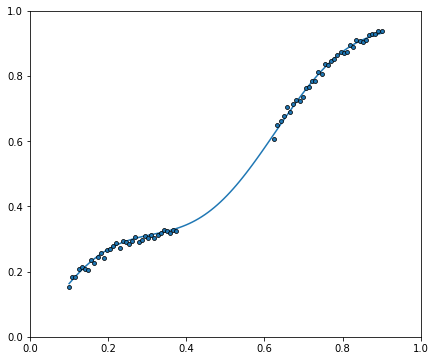

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))

ax.set_ylim([0, 1])
ax.set_xlim([0, 1])

# Visualize the training data
ax.scatter(X_obs, y_obs,
              zorder=9999,  # place these on top
              s=16,
              color='tab:blue',
              linewidth=0.75,
              edgecolor='k'
              )
ax.plot(X, f(X))



Initialize a Monotonic GP model

In [4]:
ind_points = np.linspace(xmin, xmax, 10)[:, None]  # inducing point locations
kernel = gpflow.kernels.Matern52(lengthscales=0.2, variance=0.01)
likelihood = gpflow.likelihoods.Gaussian(variance=0.01)
model = PathwiseMonotonicSVGP(kernel=kernel,
                              likelihood=likelihood,
                              inducing_variable=ind_points)

gpflow.utilities.set_trainable(model.inducing_variable, False)

2022-02-16 12:11:45.083574: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Training

In [5]:
# Sample-based training
num_steps = 100
step_sizes = [1e-1, 1e-2, 1e-3]
boundaries = [k * num_steps // len(step_sizes) for k in range(1, len(step_sizes))]
schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, step_sizes)
optimizer = tf.keras.optimizers.Adam(schedule)

training_loss = model.training_loss_closure(data=(X_obs, y_obs), compile=True)
trainables = model.trainable_variables
step_iterator = tqdm(range(num_steps))

times = []
for step in step_iterator:
    start_time = time.time()
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(trainables)
        loss = training_loss()

    grads = tape.gradient(loss, trainables)
    grads_and_vars = tuple(zip(grads, trainables))
    optimizer.apply_gradients(grads_and_vars)
    end_time = time.time()
    loss_ema = loss if (step == 0) else loss_ema + 0.25 * (loss - loss_ema)
    step_iterator.set_postfix_str(f'EMA(loss): {loss_ema:.3e}')

100%|██████████| 100/100 [03:58<00:00,  2.38s/it, EMA(loss): -1.903e+02]


In [6]:
Xnew = tf.linspace(tf.cast(0.0, floatx()), tf.cast(1.0, floatx()), 100)
with model.temporary_paths(num_samples=1000, num_bases=1024) as temp_paths:
    fnew = tf.squeeze(model.predict_f_samples(Xnew[:, None]))

In [7]:
mean = np.mean(fnew, axis=0)
std = np.std(fnew, axis=0)

Plot posterior

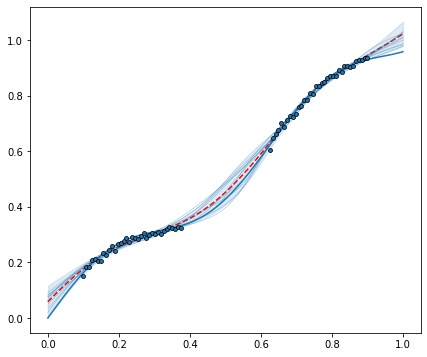

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
# Visualize the training data
ax.scatter(X_obs, y_obs,
              zorder=9999,  # place these on top
              s=16,
              color='tab:blue',
              linewidth=0.75,
              edgecolor='k'
              )

ax.fill_between(Xnew,
                mean - 2*std,
                mean + 2*std,
                color='tab:blue',
                alpha=0.15)

ax.plot(Xnew, mean, '--', color='r')

ax.plot(Xnew, f(Xnew))

ax.plot(Xnew, tf.transpose(fnew[:10], [1, 0]), alpha=0.5, linewidth=0.5, color='tab:blue')  # plot a few samples